# Taller: Regresion Lineal y PCA (Dataset de Prostata)

**Problema:** predecir `lpsa` (logaritmo del PSA) a partir de variables clinicas del estudio de Stamey et al. (1989).

**Objetivos del cuaderno:**
1. Construir una regresion lineal sin regularizacion.
2. Aplicar PCA y repetir la regresion lineal.
3. Comparar los resultados y presentar conclusiones.


## 1) Carga de librerias


In [2]:
import os
from pathlib import Path

# Evita problemas de permisos de cache de Matplotlib en algunos entornos.
os.environ.setdefault("MPLCONFIGDIR", "/tmp/matplotlib")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", 30)
sns.set_theme(style="whitegrid")


## 2) Carga del dataset


In [3]:
data_path = Path("prostate_data.txt")
info_path = Path("prostate_info.txt")

if not data_path.exists():
    raise FileNotFoundError(f"No se encontro {data_path}")

df = pd.read_csv(data_path, sep=r"\s+")

print("Dimensiones:", df.shape)
print("Columnas:", list(df.columns))
print("\nDistribucion train/test:")
print(df["train"].value_counts())

df.head()


Dimensiones: (97, 10)
Columnas: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45', 'lpsa', 'train']

Distribucion train/test:
train
T    67
F    30
Name: count, dtype: int64


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [4]:
if info_path.exists():
    print(info_path.read_text(encoding="utf-8"))
else:
    print("No se encontro prostate_info.txt")


Prostate data info

Predictors (columns 1--8)

lcavol
lweight
age
lbph
svi
lcp
gleason
pgg45

outcome (column 9)

lpsa

train/test indicator (column 10)

This last column indicates which 67 observations were used as the 
"training set" and which 30 as the test set, as described on page 48
in the book.

There was an error in these data in the first edition of this
book. Subject 32 had a value of 6.1 for lweight, which translates to a
449 gm prostate! The correct value is 44.9 gm. We are grateful to
Prof. Stephen W. Link for alerting us to this error.

The features must first be scaled to have mean zero and  variance 96 (=n)
before the analyses in Tables 3.1 and beyond.  That is, if x is the  96 by 8 matrix
of features, we compute xp <- scale(x,TRUE,TRUE)



## 3) Analisis exploratorio rapido


In [5]:
numeric_cols = [c for c in df.columns if c != "train"]
df[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
lcavol,97.0,1.350010,1.178625,-1.347074,0.512824,1.446919,2.127041,3.821004
lweight,97.0,3.628943,0.428411,2.374906,3.375880,3.623007,3.876396,4.780383
age,97.0,63.865979,7.445117,41.000000,60.000000,65.000000,68.000000,79.000000
lbph,97.0,0.100356,1.450807,-1.386294,-1.386294,0.300105,1.558145,2.326302
svi,97.0,0.216495,0.413995,0.000000,0.000000,0.000000,0.000000,1.000000
lcp,97.0,-0.179366,1.398250,-1.386294,-1.386294,-0.798508,1.178655,2.904165
gleason,97.0,6.752577,0.722134,6.000000,6.000000,7.000000,7.000000,9.000000
pgg45,97.0,24.381443,28.204035,0.000000,0.000000,15.000000,40.000000,100.000000
lpsa,97.0,2.478387,1.154329,-0.430783,1.731656,2.591516,3.056357,5.582932


In [6]:
corr_lpsa = df[numeric_cols].corr(numeric_only=True)["lpsa"].sort_values(ascending=False)
corr_lpsa.to_frame("correlacion_con_lpsa")


,correlacion_con_lpsa
lpsa,1.000000
lcavol,0.734460
svi,0.566218
lcp,0.548813
lweight,0.433319
pgg45,0.422316
gleason,0.368987
lbph,0.179809
age,0.169593


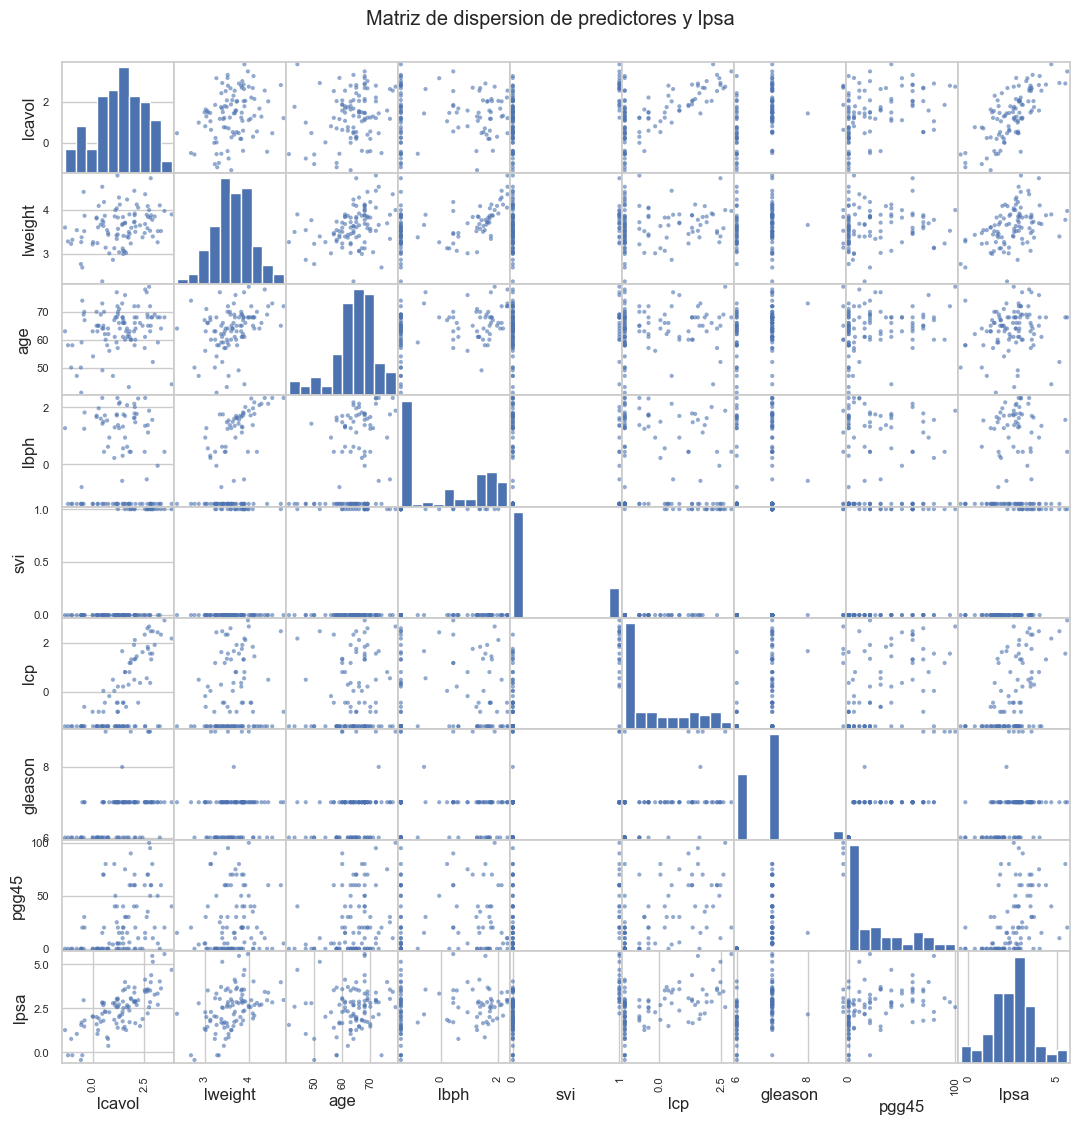

In [7]:
feature_cols = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]

# Matriz de dispersion solicitada en el enunciado.
pd.plotting.scatter_matrix(
    df[feature_cols + ["lpsa"]],
    figsize=(13, 13),
    diagonal="hist",
    alpha=0.6,
)
plt.suptitle("Matriz de dispersion de predictores y lpsa", y=0.92)
plt.show()


## 4) Preparacion de entrenamiento y prueba

Se usa la separacion oficial del archivo (`train = T` para entrenamiento, `train = F` para prueba).


In [8]:
target_col = "lpsa"

train_mask = df["train"] == "T"
test_mask = df["train"] == "F"

X_train = df.loc[train_mask, feature_cols]
X_test = df.loc[test_mask, feature_cols]
y_train = df.loc[train_mask, target_col]
y_test = df.loc[test_mask, target_col]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (67, 8)
X_test: (30, 8)
y_train: (67,)
y_test: (30,)


## 5) Modelo 1: Regresion lineal sin regularizacion

Se usa `LinearRegression` de scikit-learn (OLS, sin penalizacion).


In [9]:
model_ols = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("reg", LinearRegression()),
    ]
)

model_ols.fit(X_train, y_train)

y_pred_train_ols = model_ols.predict(X_train)
y_pred_test_ols = model_ols.predict(X_test)

def regression_metrics(y_true, y_pred):
    mse = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

metrics_train_ols = regression_metrics(y_train, y_pred_train_ols)
metrics_test_ols = regression_metrics(y_test, y_pred_test_ols)

pd.DataFrame([metrics_train_ols, metrics_test_ols], index=["Train", "Test"]).round(4)


,MSE,RMSE,MAE,R2
Train,0.4392,0.6627,0.4986,0.6944
Test,0.5213,0.7220,0.5234,0.5034


In [10]:
reg = model_ols.named_steps["reg"]
coef_ols = pd.DataFrame({
    "variable": feature_cols,
    "coef_estandarizado": reg.coef_,
}).sort_values("coef_estandarizado", key=np.abs, ascending=False)

coef_ols


,variable,coef_estandarizado
0,lcavol,0.711041
4,svi,0.307300
1,lweight,0.290450
5,lcp,-0.286841
7,pgg45,0.275268
3,lbph,0.210420
2,age,-0.141482
6,gleason,-0.020757


## 6) Modelo 2: PCA + Regresion lineal

Se ajusta PCA en train y se conserva al menos 95% de varianza explicada.


In [11]:
model_pca_ols = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, svd_solver="full")),
        ("reg", LinearRegression()),
    ]
)

model_pca_ols.fit(X_train, y_train)

y_pred_train_pca = model_pca_ols.predict(X_train)
y_pred_test_pca = model_pca_ols.predict(X_test)

metrics_train_pca = regression_metrics(y_train, y_pred_train_pca)
metrics_test_pca = regression_metrics(y_test, y_pred_test_pca)

pca_step = model_pca_ols.named_steps["pca"]
n_components = pca_step.n_components_

print(f"Numero de componentes seleccionadas: {n_components}")

pca_info = pd.DataFrame({
    "Componente": np.arange(1, len(pca_step.explained_variance_ratio_) + 1),
    "Varianza explicada": pca_step.explained_variance_ratio_,
})
pca_info["Varianza acumulada"] = pca_info["Varianza explicada"].cumsum()

pca_info.round(4)


Numero de componentes seleccionadas: 7


,Componente,Varianza explicada,Varianza acumulada
0,1,0.4283,0.4283
1,2,0.2041,0.6324
2,3,0.1296,0.7620
3,4,0.0773,0.8392
4,5,0.0569,0.8961
5,6,0.0471,0.9432
6,7,0.0350,0.9782


In [12]:
pd.DataFrame([metrics_train_pca, metrics_test_pca], index=["Train", "Test"]).round(4)


,MSE,RMSE,MAE,R2
Train,0.4835,0.6953,0.5141,0.6636
Test,0.4483,0.6696,0.5259,0.5729


## 7) Comparacion final de modelos


In [13]:
comparison = pd.DataFrame([
    {"Modelo": "OLS sin regularizacion", "Conjunto": "Train", **metrics_train_ols},
    {"Modelo": "OLS sin regularizacion", "Conjunto": "Test", **metrics_test_ols},
    {"Modelo": f"PCA(95%) + OLS (k={n_components})", "Conjunto": "Train", **metrics_train_pca},
    {"Modelo": f"PCA(95%) + OLS (k={n_components})", "Conjunto": "Test", **metrics_test_pca},
])

comparison.round(4)


,Modelo,Conjunto,MSE,RMSE,MAE,R2
0,OLS sin regularizacion,Train,0.4392,0.6627,0.4986,0.6944
1,OLS sin regularizacion,Test,0.5213,0.7220,0.5234,0.5034
2,PCA(95%) + OLS (k=7),Train,0.4835,0.6953,0.5141,0.6636
3,PCA(95%) + OLS (k=7),Test,0.4483,0.6696,0.5259,0.5729


In [14]:
test_comparison = comparison[comparison["Conjunto"] == "Test"].set_index("Modelo")
test_comparison[["MSE", "RMSE", "MAE", "R2"]].sort_values("RMSE").round(4)


,MSE,RMSE,MAE,R2
Modelo,,,,
PCA(95%) + OLS (k=7),0.4483,0.6696,0.5259,0.5729
OLS sin regularizacion,0.5213,0.7220,0.5234,0.5034


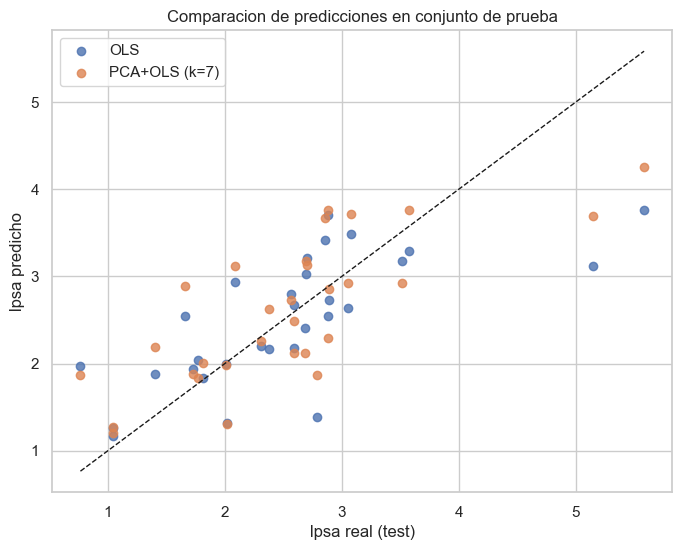

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_ols, alpha=0.8, label="OLS")
plt.scatter(y_test, y_pred_test_pca, alpha=0.8, label=f"PCA+OLS (k={n_components})")

lim_min = min(y_test.min(), y_pred_test_ols.min(), y_pred_test_pca.min())
lim_max = max(y_test.max(), y_pred_test_ols.max(), y_pred_test_pca.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], "k--", linewidth=1)

plt.xlabel("lpsa real (test)")
plt.ylabel("lpsa predicho")
plt.title("Comparacion de predicciones en conjunto de prueba")
plt.legend()
plt.show()


## 8) Conclusiones

1. La regresion lineal sin regularizacion (`LinearRegression`) funciona como linea base interpretable.
2. PCA reduce dimensionalidad y puede mejorar la generalizacion si hay colinealidad entre predictores.
3. La decision final debe tomarse con las metricas en test (`RMSE` menor y `R2` mayor son mejores).
4. Si el modelo PCA+OLS mejora en test frente a OLS, es preferible para prediccion; si no mejora, conviene mantener OLS por simplicidad e interpretabilidad.


In [16]:
print("Metricas en test")
print("OLS:", {k: round(v, 4) for k, v in metrics_test_ols.items()})
print(f"PCA+OLS (k={n_components}):", {k: round(v, 4) for k, v in metrics_test_pca.items()})

if metrics_test_pca["RMSE"] < metrics_test_ols["RMSE"]:
    print("\nConclusion automatica: PCA+OLS obtiene mejor RMSE en prueba.")
elif metrics_test_pca["RMSE"] > metrics_test_ols["RMSE"]:
    print("\nConclusion automatica: OLS obtiene mejor RMSE en prueba.")
else:
    print("\nConclusion automatica: ambos modelos empatan en RMSE de prueba.")


Metricas en test
OLS: {'MSE': 0.5213, 'RMSE': 0.722, 'MAE': 0.5234, 'R2': 0.5034}
PCA+OLS (k=7): {'MSE': 0.4483, 'RMSE': 0.6696, 'MAE': 0.5259, 'R2': 0.5729}

Conclusion automatica: PCA+OLS obtiene mejor RMSE en prueba.
